# Survival Analysis

This Notebook contains analysis of churn for the Telecom Company customers:
* Exploratory Data Analysis is made
* Data cleaning/preprocessing
* Then regression survival analysis models are fitted to the data
* Summary Analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lifelines as lf
from lifelines.plotting import plot_lifetimes

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(9,4)})

In [86]:
churn = pd.read_csv('https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv')

# EDA

In [148]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [149]:
churn.shape

(7043, 21)

In [150]:
churn[churn.duplicated() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [151]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [152]:
for col in churn.select_dtypes(include='object').columns:
    print(churn[col].value_counts(dropna=False))
    print()

7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

Male      3555
Female    3488
Name: gender, dtype: int64

No     3641
Yes    3402
Name: Partner, dtype: int64

No     4933
Yes    2110
Name: Dependents, dtype: int64

Yes    6361
No      682
Name: PhoneService, dtype: int64

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, 

In [153]:
churn['SeniorCitizen'].value_counts(dropna=False)

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [154]:
churn['tenure'].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [155]:
churn['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

EDA First Conclusions:
- **Churn** - client left or not. Target variable
- **tenure** - months with company. Duration variable
- **customerID** - unique customer ID. Feature can be dropped
- **SeniorCitizen** - is client a senior or not. Is a categorical feature with 2 values. Chould be converted to object type
- **Dependents** - has dependents in family or not
- **TotalCharges** - is actually float variable. Chould be converted from object to float

# Data Preparation

## Senior Citizen

In [161]:
churn.SeniorCitizen = np.where(churn.SeniorCitizen == 1, 'Yes', 'No')

## Total Charges

In [162]:
churn['TotalCharges'].isna().sum()

0

After first convertation to float try it appeared that some values couldn't be converted. Let's check them

In [163]:
churn[churn['TotalCharges'].str.contains(' ')][['Churn', 'tenure', 'TotalCharges']]

,Churn,tenure,TotalCharges
488,No,0,
753,No,0,
936,No,0,
1082,No,0,
1340,No,0,
3331,No,0,
3826,No,0,
4380,No,0,
5218,No,0,
6670,No,0,


In [164]:
len(churn[churn['TotalCharges'].str.contains(' ')])

11

In [165]:
len(churn[churn['tenure'] == 0])

11

TotalCharges column has almost all float valus, but 11 values are empty ' '. All 1 with tenure 0 months and Churn = No
<br>
tenure is 0 months ONLY in 11 rows
<br>
So Total Charges are empty for 11 newcommers. Value 0 could be put instead of empty TotalCharges values

In [166]:
churn.TotalCharges = np.where(churn.TotalCharges.str.contains(' '), '0', churn.TotalCharges)
churn['TotalCharges'] = churn['TotalCharges'].astype(float)

In [167]:
len(churn[churn['TotalCharges'] == 0])

11

There were no other 0 values in TotalCharges

In [168]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Visual EDA

### Churn Distribution

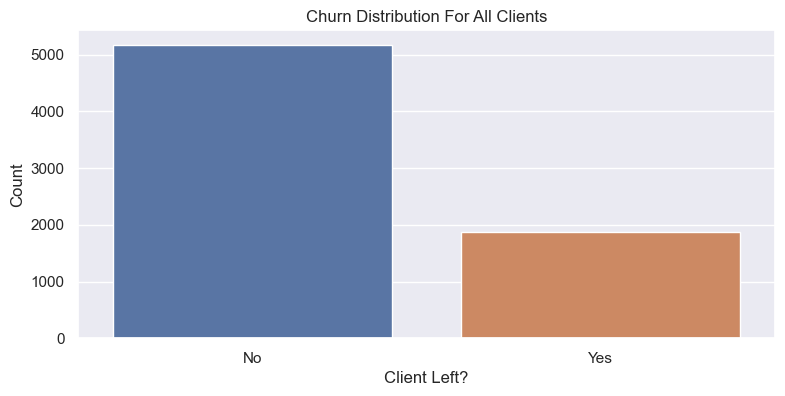

In [169]:
sns.countplot(x='Churn', data=churn)
plt.xlabel('Client Left?')
plt.ylabel('Count')
plt.title('Churn Distribution For All Clients')
plt.show()

### Distribution of Month Number with Company

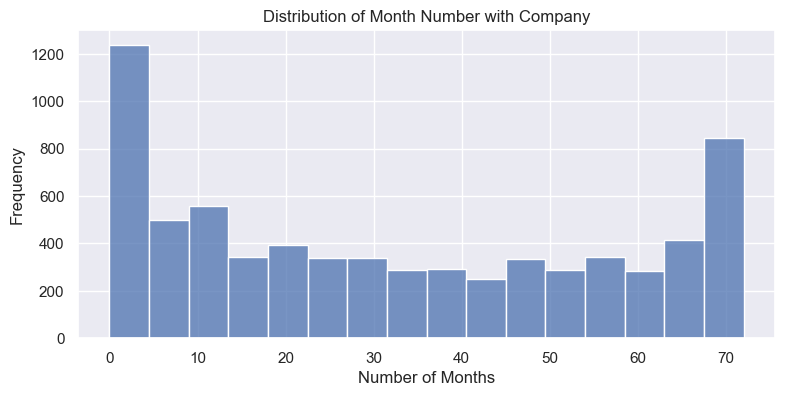

In [170]:
sns.histplot(churn.tenure, kde=False)
plt.xlabel('Number of Months')
plt.ylabel('Frequency')
plt.title('Distribution of Month Number with Company')
plt.show()

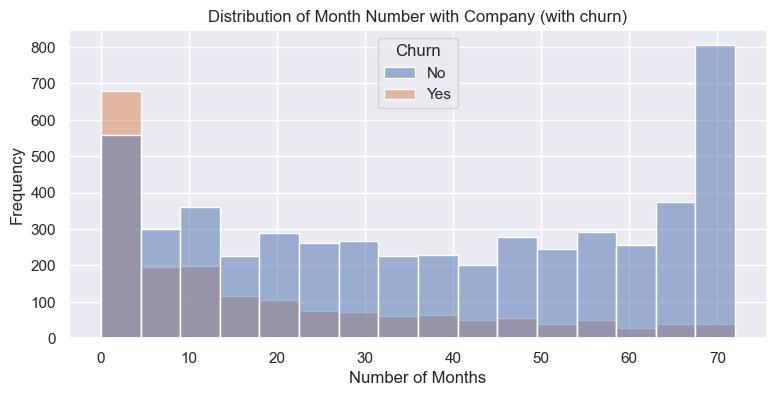

In [171]:
sns.histplot(data=churn, x='tenure', kde=False, hue='Churn')
plt.xlabel('Number of Months')
plt.ylabel('Frequency')
plt.title('Distribution of Month Number with Company (with churn)')
plt.show()

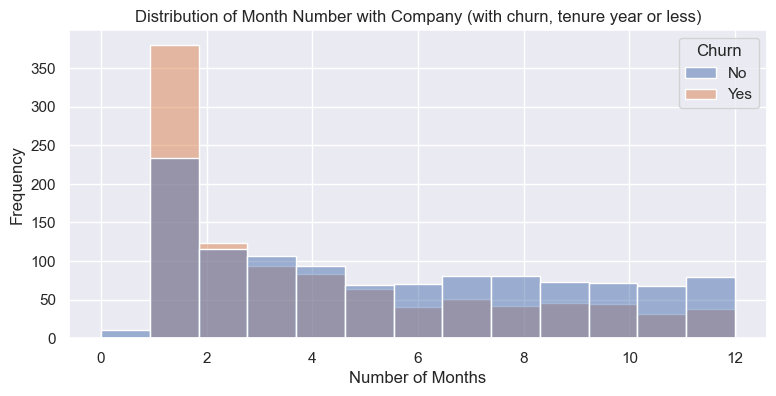

In [172]:
sns.histplot(data=churn[churn.tenure <= 12], x='tenure', kde=False, hue='Churn')
plt.xlabel('Number of Months')
plt.ylabel('Frequency')
plt.title('Distribution of Month Number with Company (with churn, tenure year or less)')
plt.show()

## Lifetime plots, analysing only tenure and Churn features

In [245]:
def plot_lifetime_on_sample(df, n=50):
    churn_sample = df.sample(n=n, replace=False, random_state=42).copy()
    churn_sample = churn_sample.reset_index(drop=True)
    ax = plot_lifetimes(churn_sample['tenure'],
                        event_observed=churn_sample['Churn'])
    plt.show()

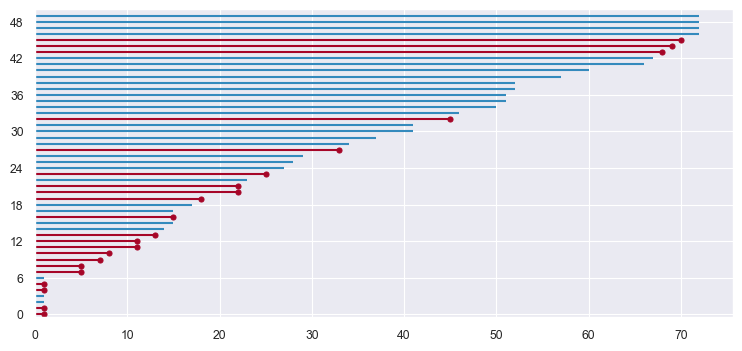

In [246]:
plot_lifetime_on_sample(churn)

In [247]:
year_customers = churn[churn['tenure'] <= 12].copy()
year_customers.reset_index(inplace=True)

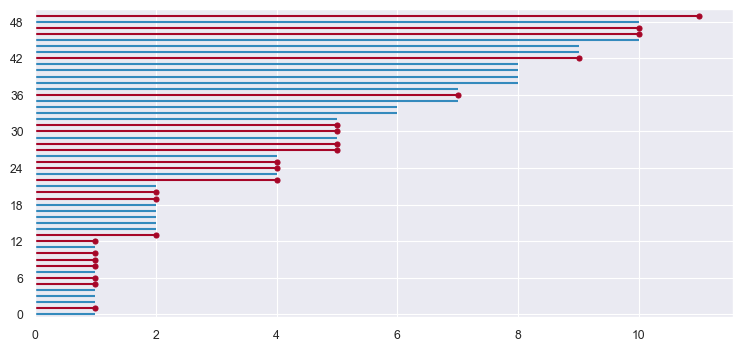

In [248]:
plot_lifetime_on_sample(year_customers)

In [249]:
more_than_year_customers = churn[churn['tenure'] > 12].copy()
more_than_year_customers.reset_index(inplace=True)

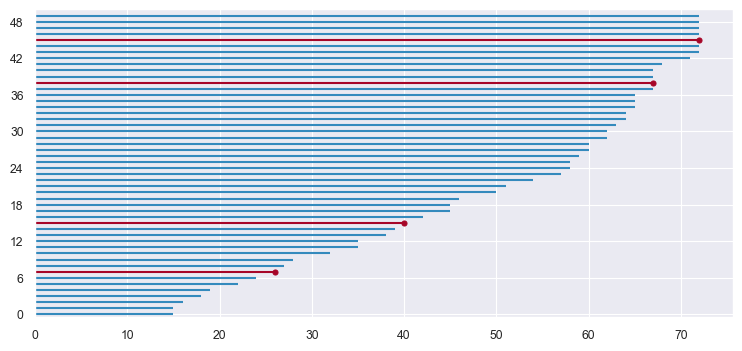

In [250]:
plot_lifetime_on_sample(more_than_year_customers)

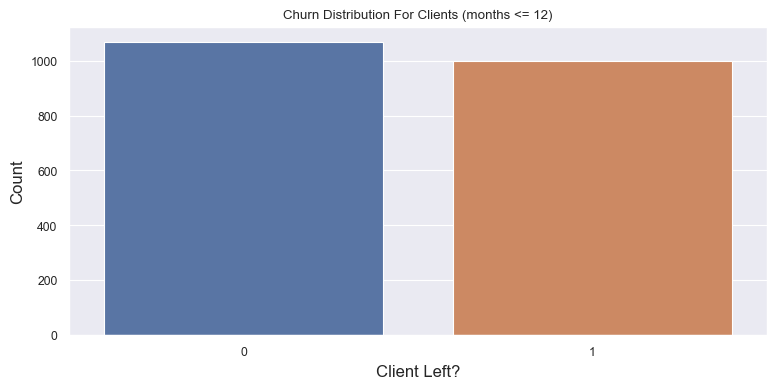

In [251]:
sns.countplot(x='Churn', data=year_customers)
plt.xlabel('Client Left?')
plt.ylabel('Count')
plt.title('Churn Distribution For Clients (months <= 12)')
plt.show()

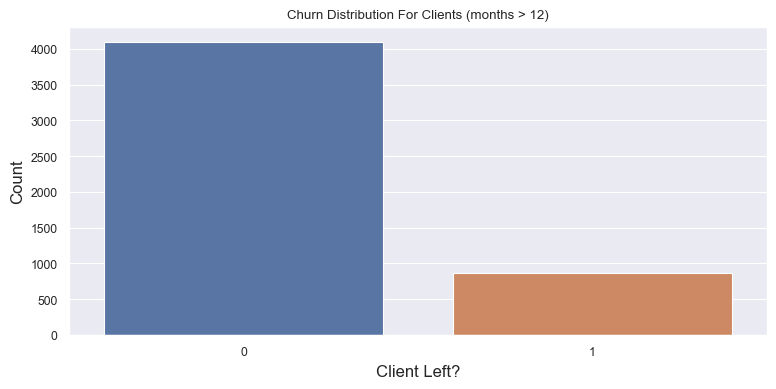

In [252]:
sns.countplot(x='Churn', data=more_than_year_customers)
plt.xlabel('Client Left?')
plt.ylabel('Count')
plt.title('Churn Distribution For Clients (months > 12)')
plt.show()

Conclusion:
* Peopele who are with company one year or less have a big chance to leave
* So the very important clients to hold are the clients who are less than 1 year with the company

## Categorical features

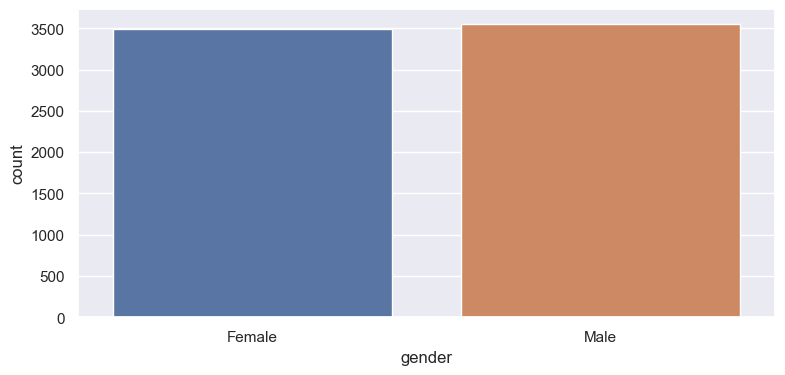

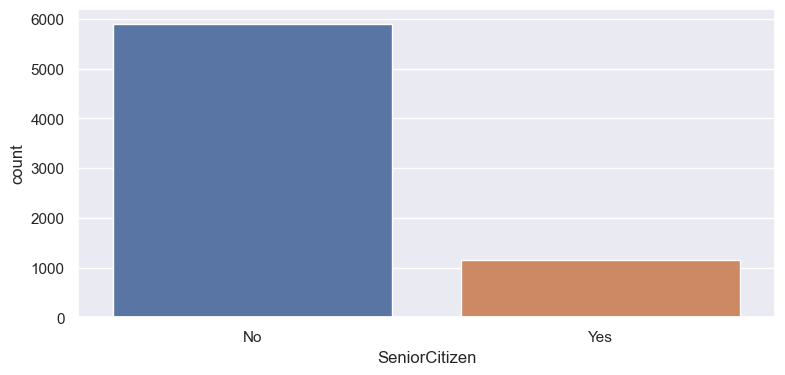

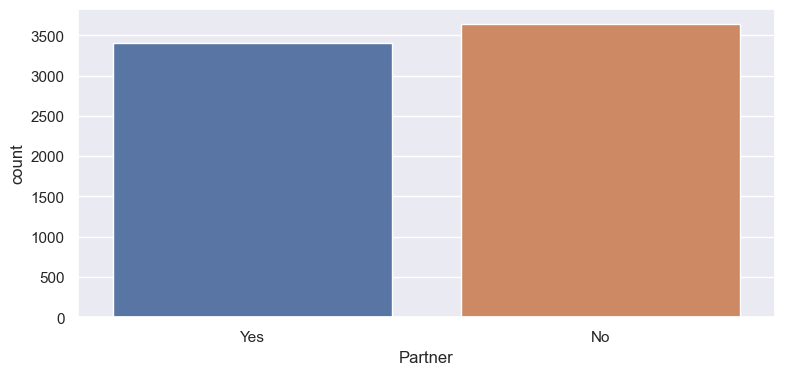

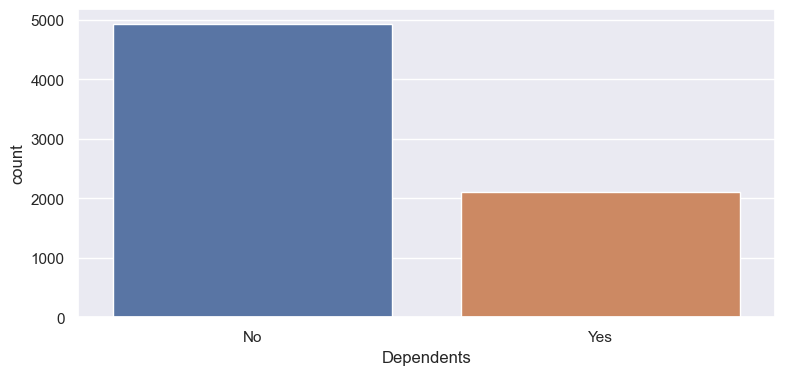

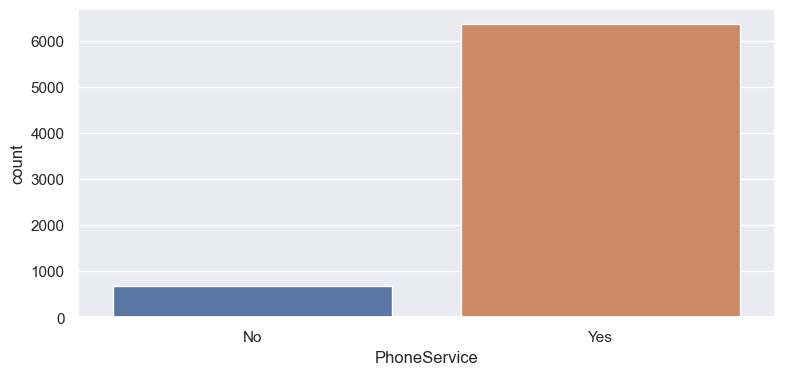

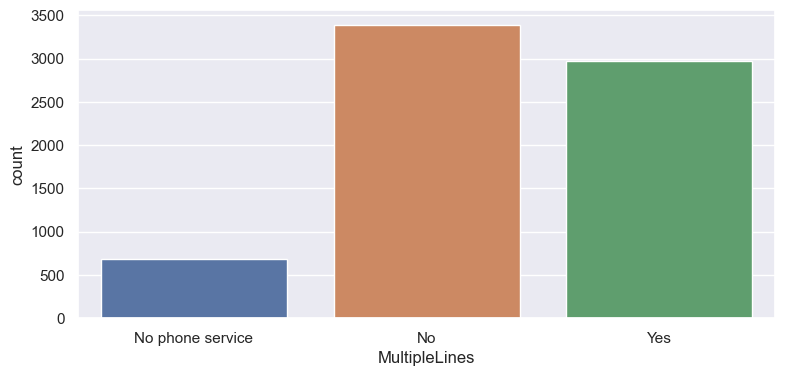

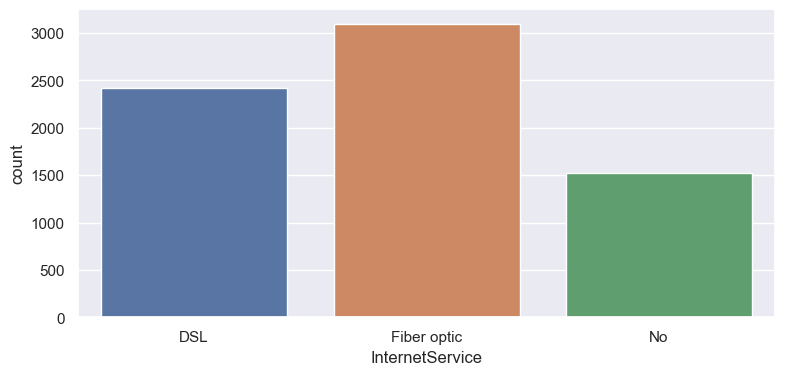

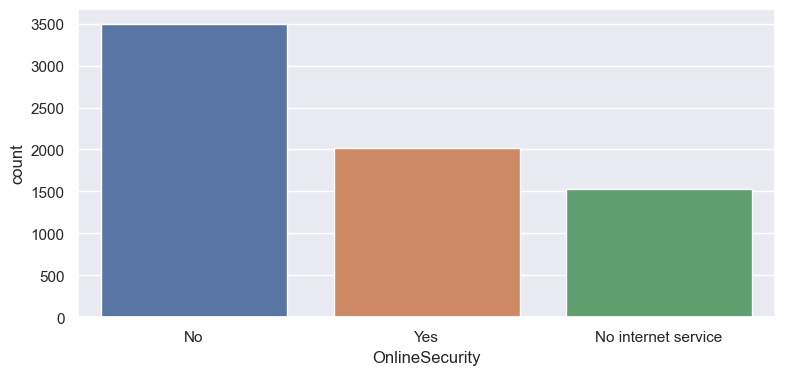

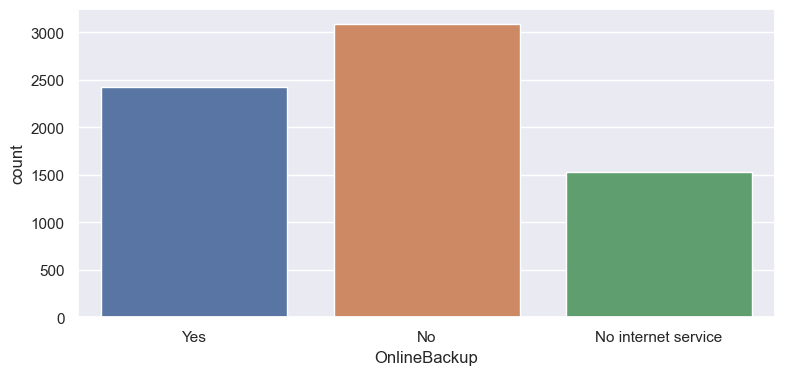

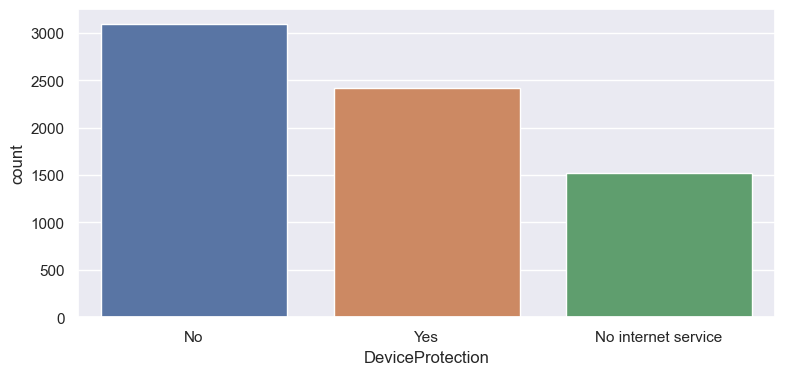

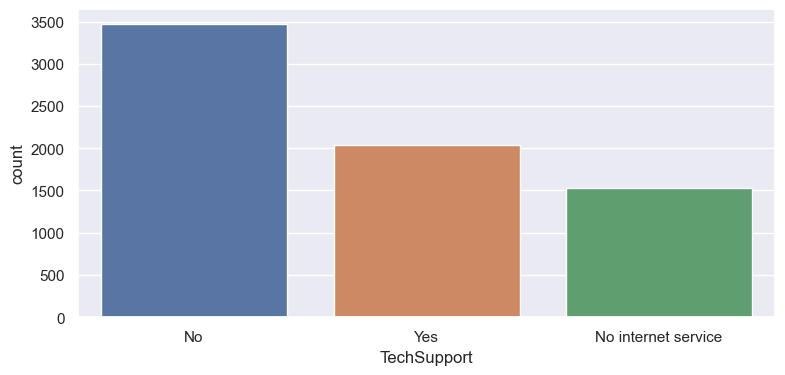

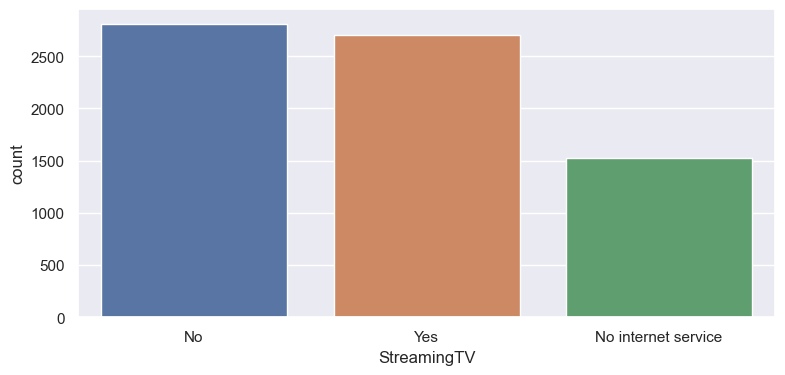

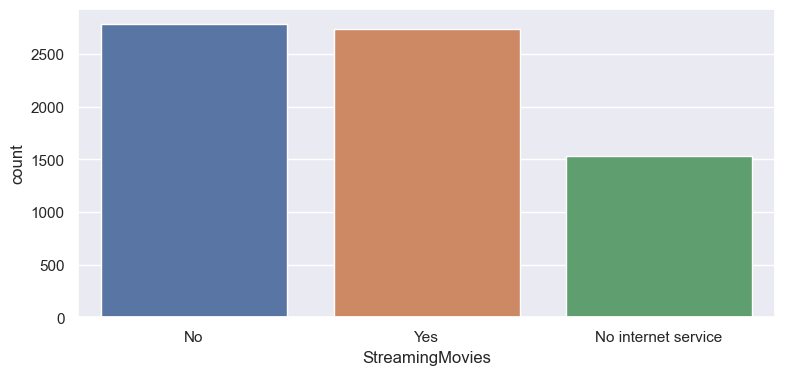

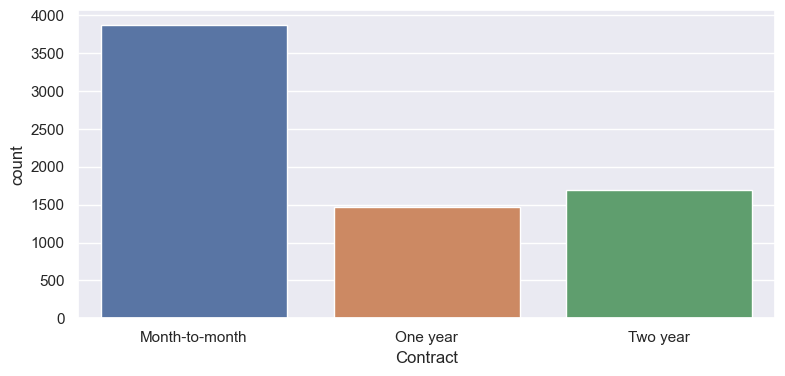

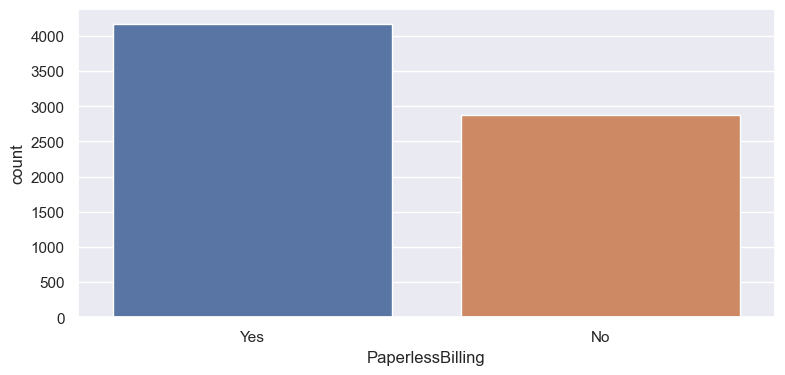

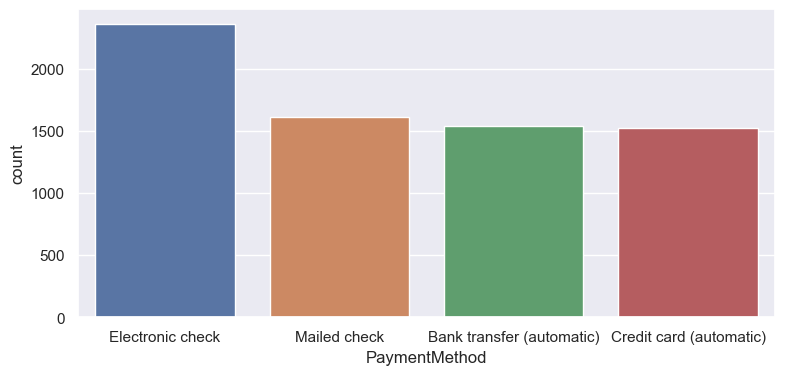

In [173]:
for col in churn.select_dtypes(include='object').columns:
    if col != 'Churn' and col != 'customerID':
        sns.countplot(data = churn, x = col)
        plt.show()

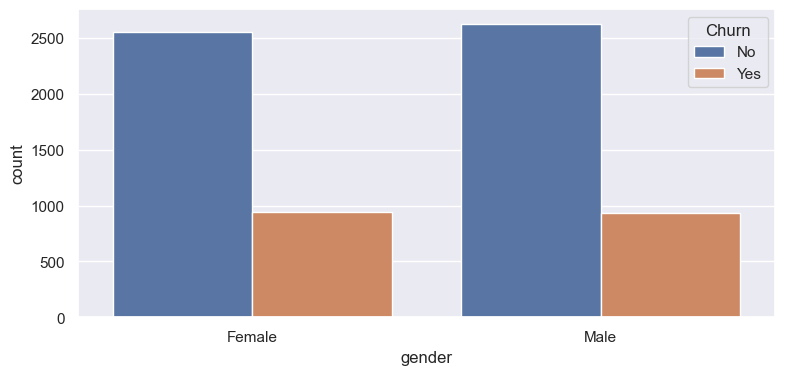

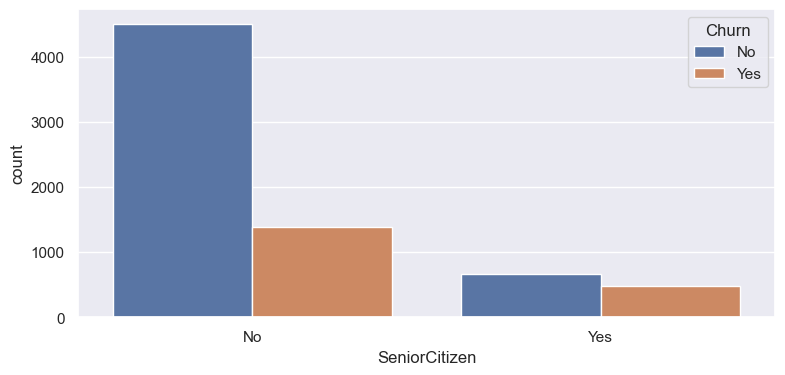

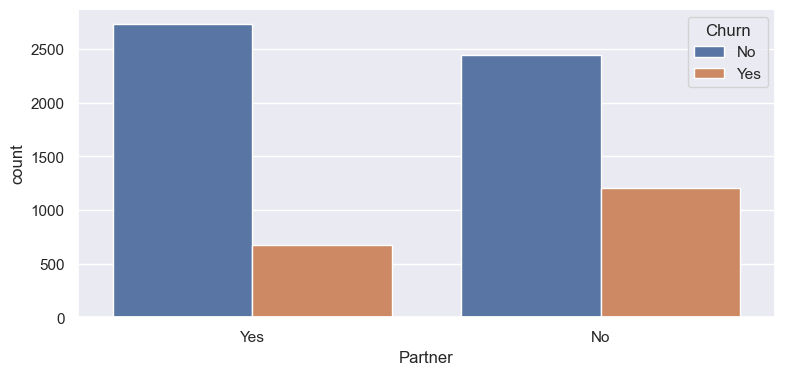

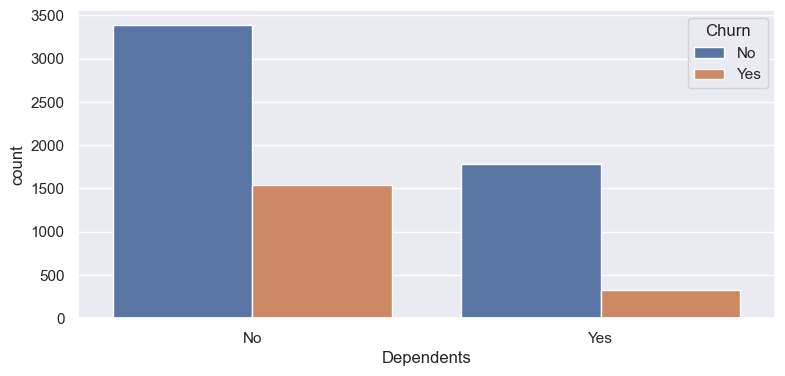

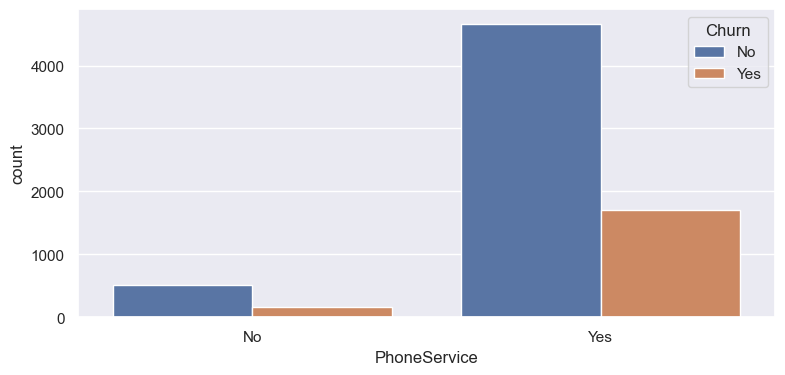

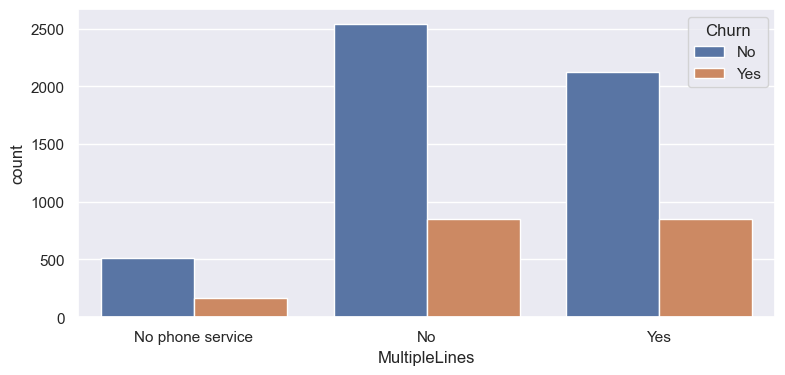

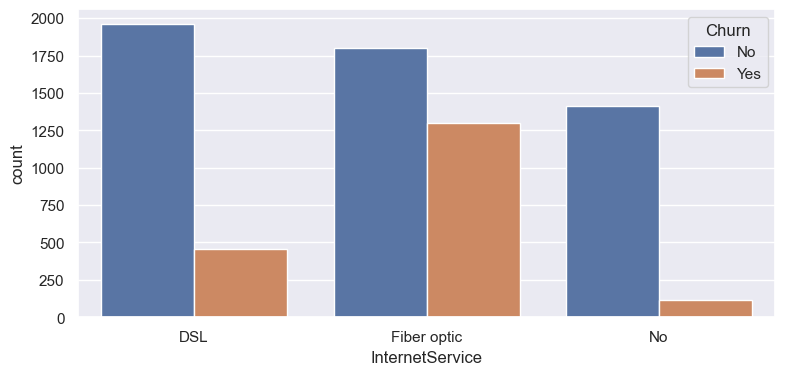

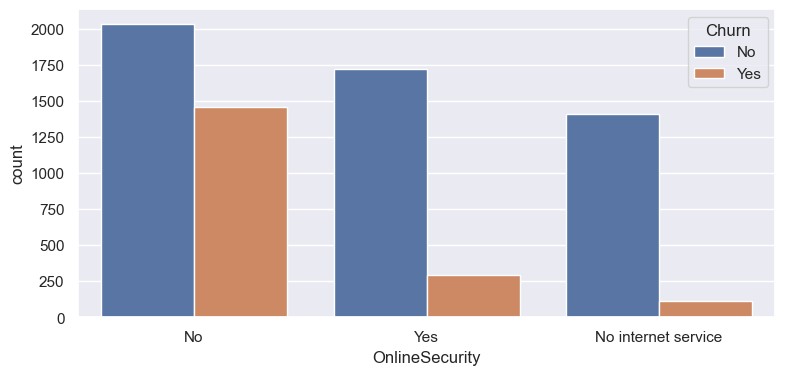

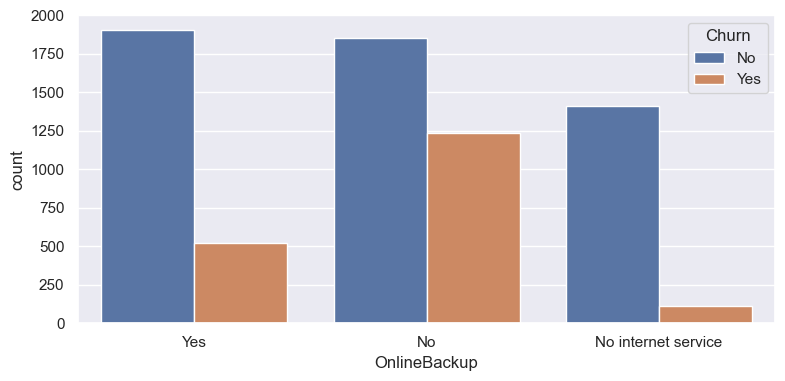

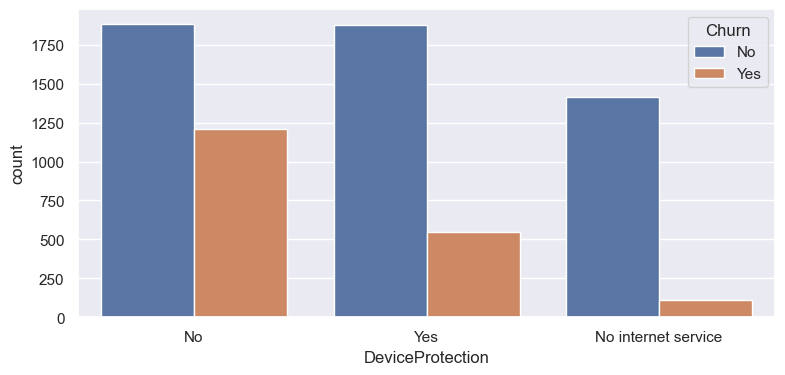

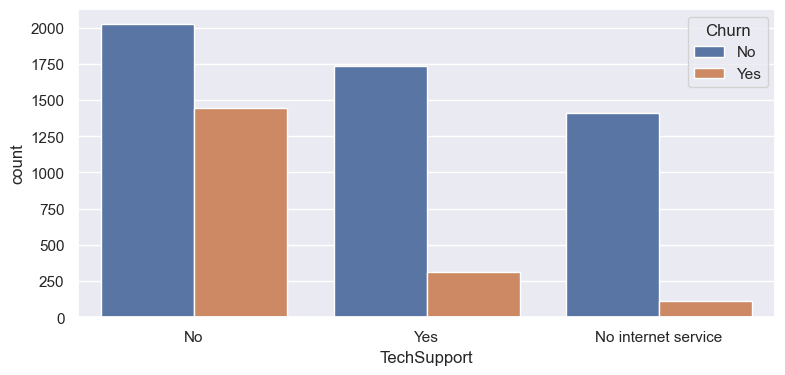

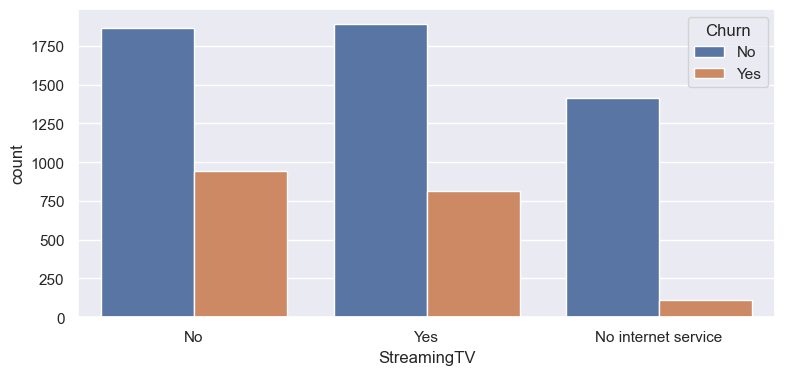

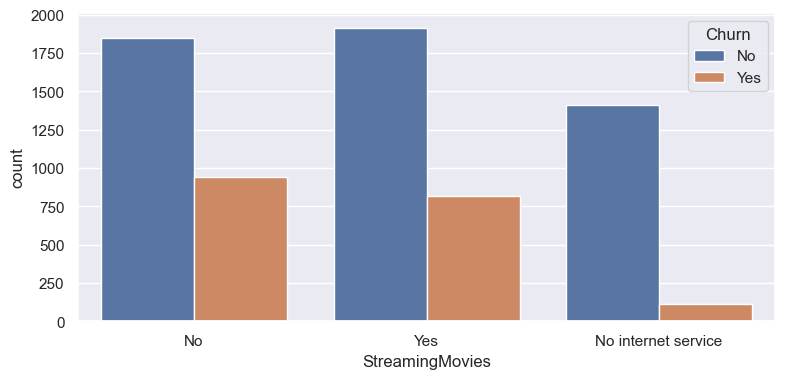

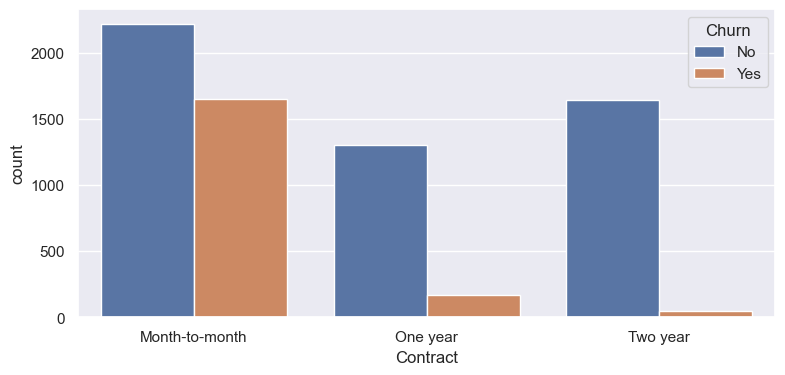

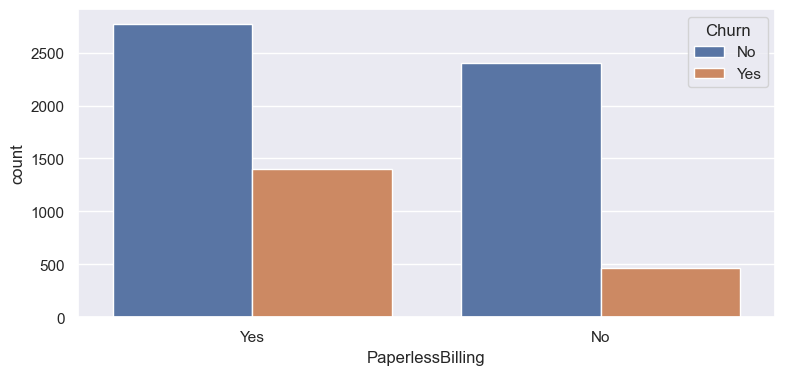

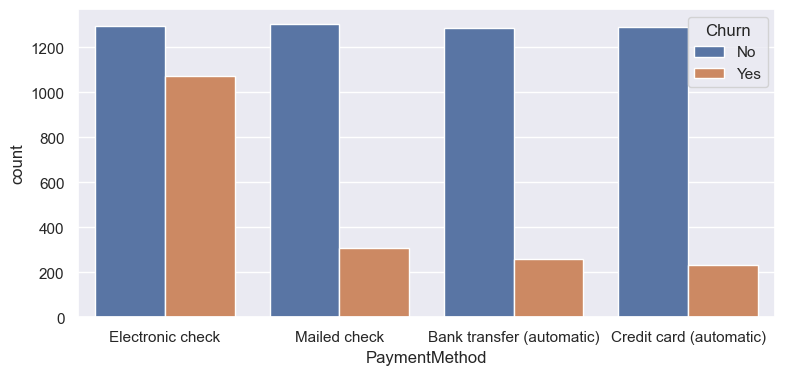

In [174]:
for col in churn.select_dtypes(include='object').columns:
    if col != 'Churn' and col != 'customerID':
        sns.countplot(data = churn, x = col, hue='Churn')
        plt.show()

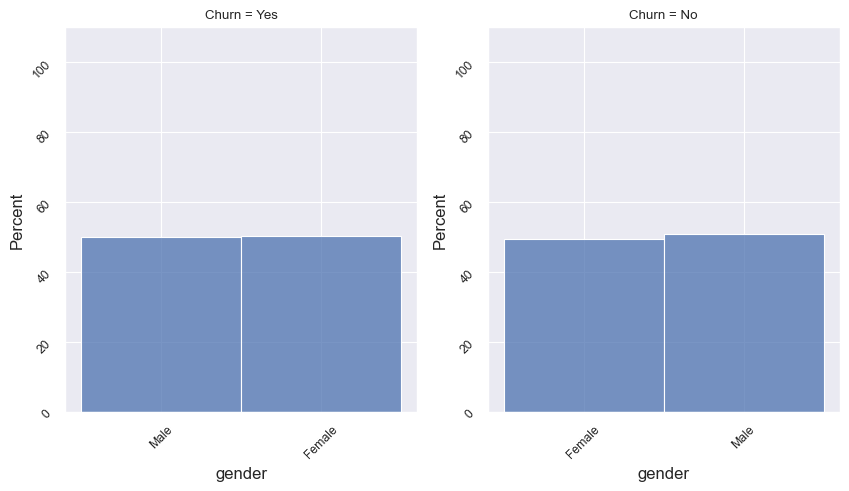

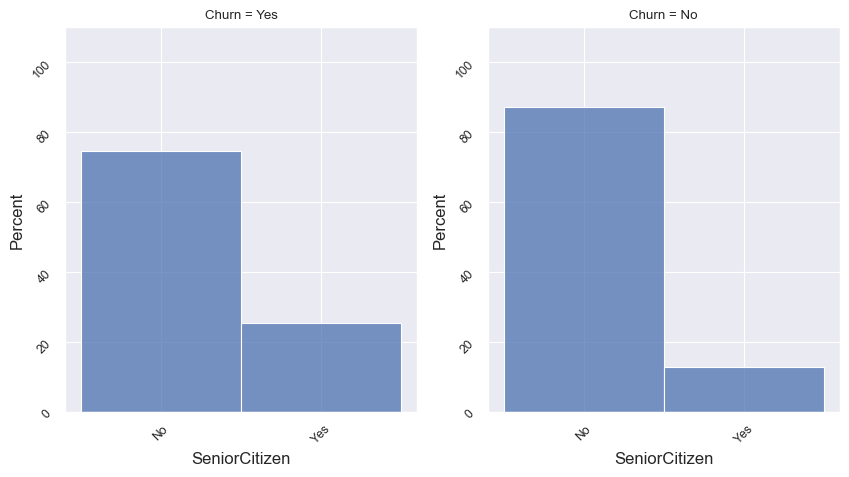

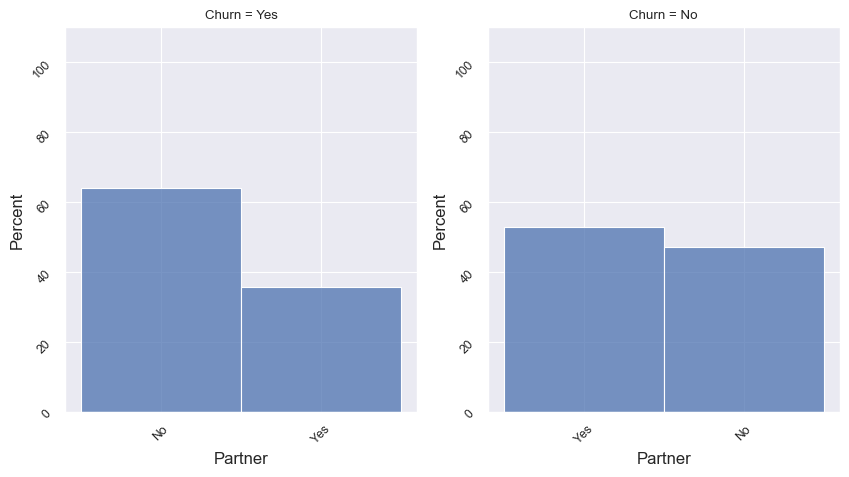

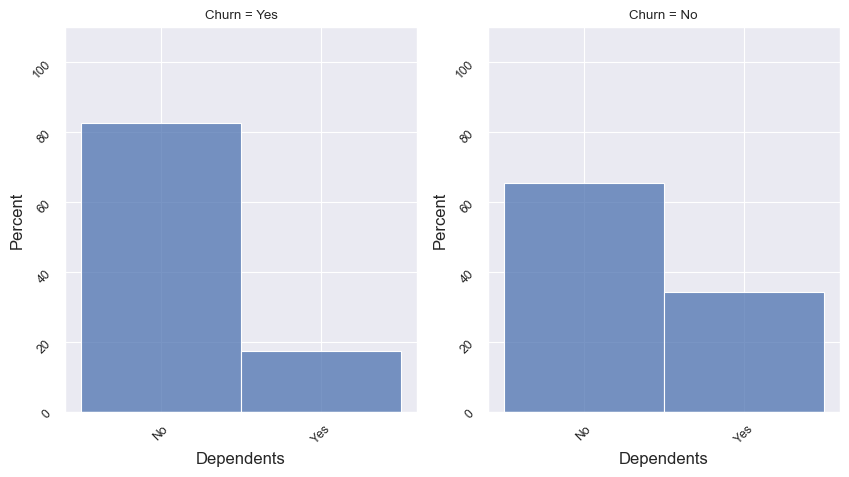

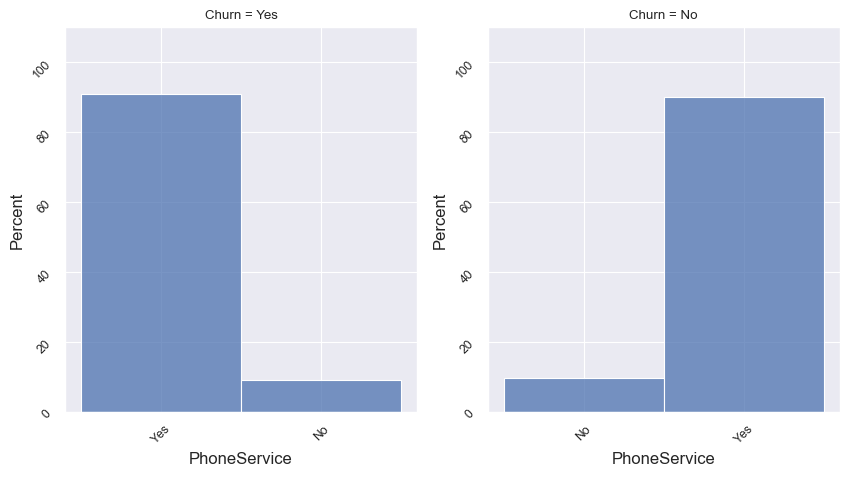

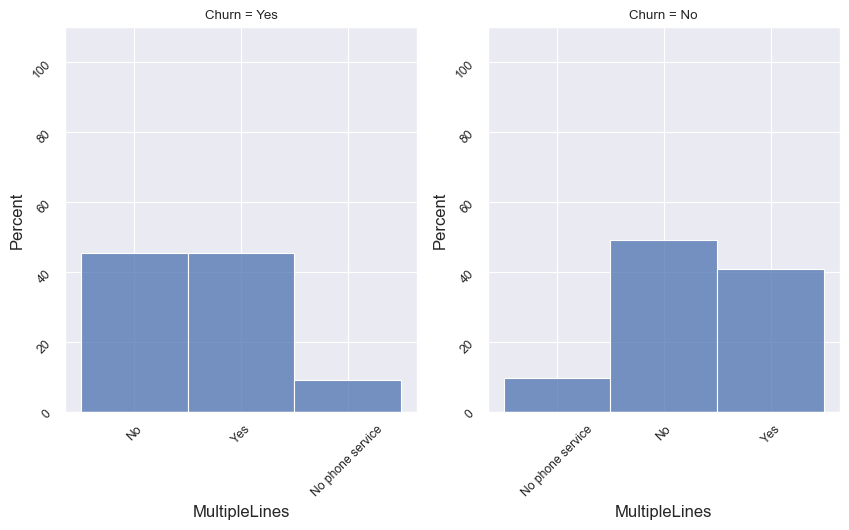

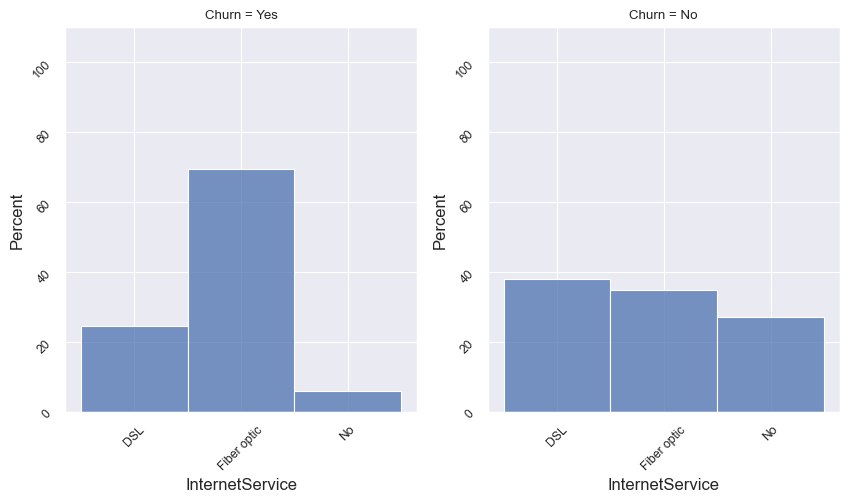

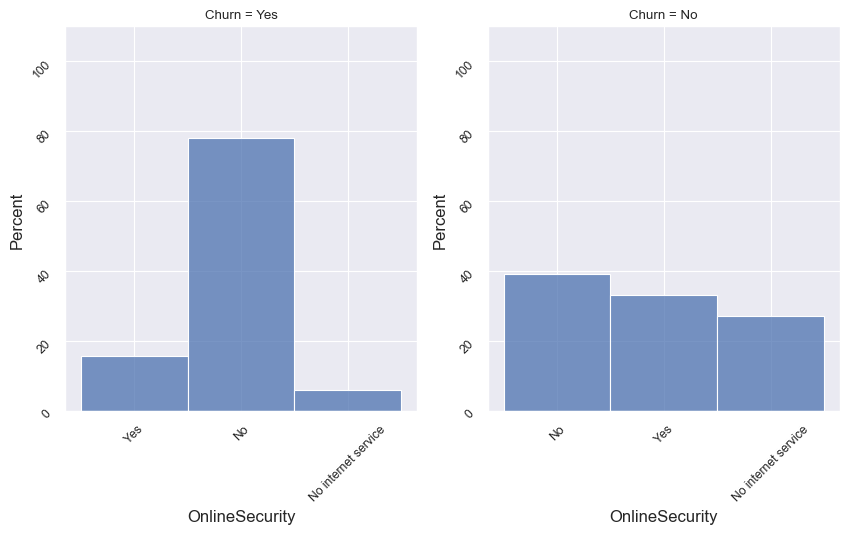

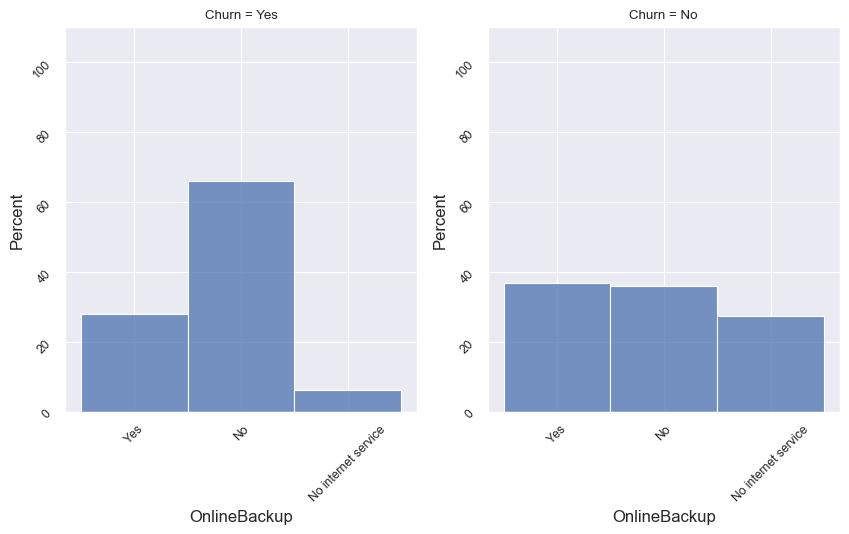

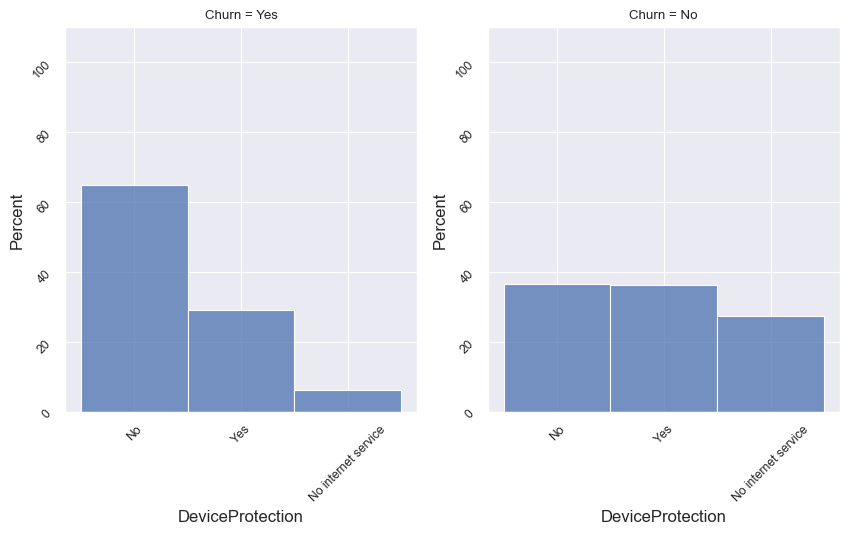

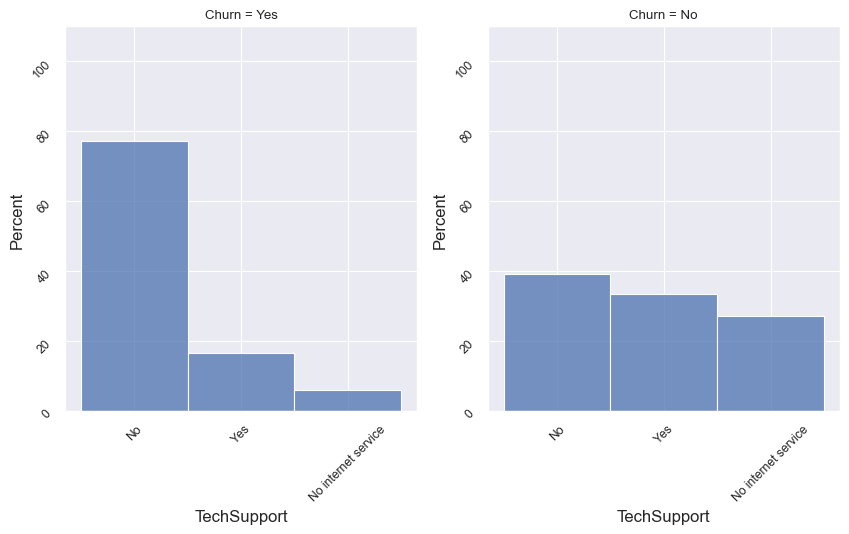

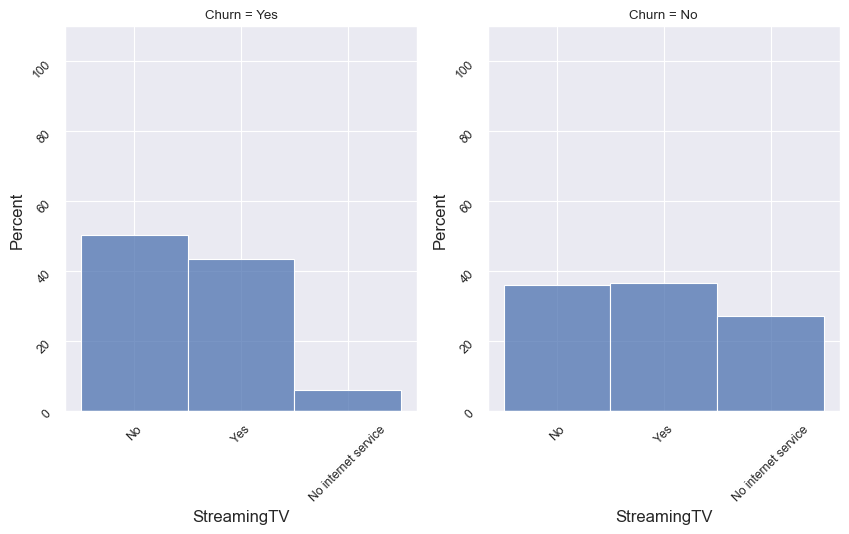

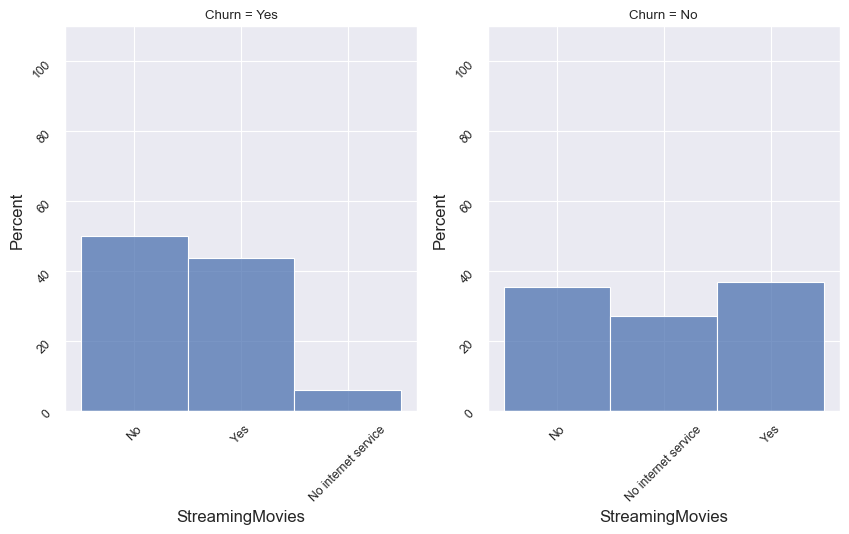

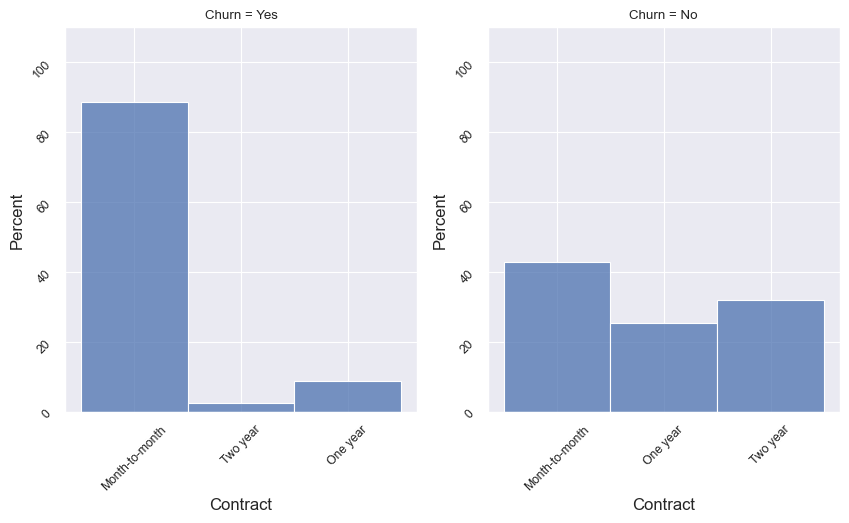

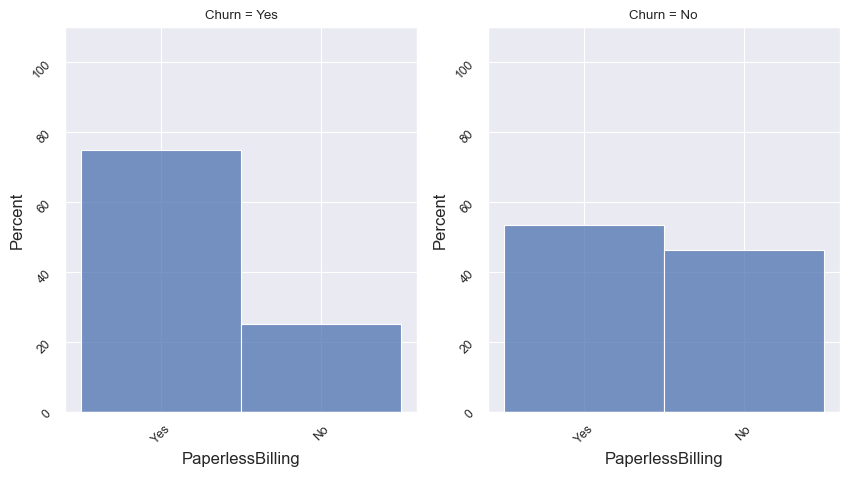

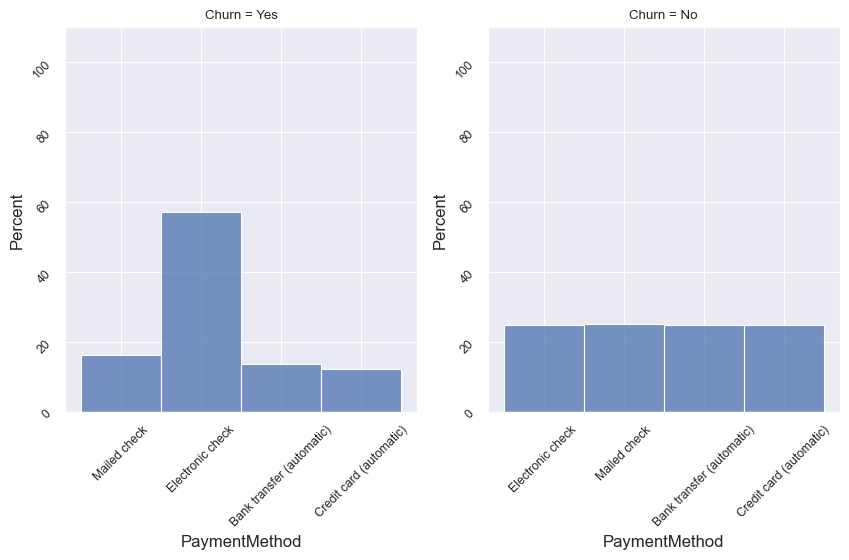

In [200]:
churn_yes = churn[churn['Churn'] == 'Yes'].copy()
churn_no = churn[churn['Churn'] == 'No'].copy()

for col in churn.select_dtypes(include='object').columns:
    if col != 'Churn' and col != 'customerID':
        fig = plt.figure(figsize=(10,5))
        ax1 = fig.add_subplot(121)
        sns.histplot(data = churn_yes, x = col, stat='percent', ax=ax1)
        ax1.set_ylim(0,110)
        ax1.set_title('Churn = Yes')
        ax1.tick_params(rotation=45)
        
        ax2 = fig.add_subplot(122)
        sns.histplot(data = churn_no, x = col, stat='percent', ax=ax2)
        ax2.set_ylim(0,110)
        ax2.set_title('Churn = No')
        ax2.tick_params(rotation=45)
        
        plt.show()

In [197]:
for col in churn.select_dtypes(include='object').columns:
    if col != 'Churn' and col != 'customerID':
        print(churn[[col, 'Churn', 'customerID']].groupby([col, 'Churn']).agg('count'))
        print()

              customerID
gender Churn            
Female No           2549
       Yes           939
Male   No           2625
       Yes           930

                     customerID
SeniorCitizen Churn            
No            No           4508
              Yes          1393
Yes           No            666
              Yes           476

               customerID
Partner Churn            
No      No           2441
        Yes          1200
Yes     No           2733
        Yes           669

                  customerID
Dependents Churn            
No         No           3390
           Yes          1543
Yes        No           1784
           Yes           326

                    customerID
PhoneService Churn            
No           No            512
             Yes           170
Yes          No           4662
             Yes          1699

                        customerID
MultipleLines    Churn            
No               No           2541
                 Yes           8

Conclusions:
* Churn classes are imbalanced
* If a client is with company more than a year, the risk of churn is less
* PhoneService (interesting dependency, if there is no phone service people leave the company not so frequent)
* InternetService - if a customer left, in most cases he had Fiber optic
* OnlineSecurity - if a customer left, in most cases he had No online security
* OnlineBackup - if a customer left, in most cases he had No online backup
* DeviceProtection - if a customer left, in most cases he had No device protection
* TechSupport - if a customer left, in most cases he had No tech support
* Contract - if a customer left, in most cases he had Month-to-month contract
* PaymentMethod - if a customer left, in most cases he had Electronic check
* Features that have significantly different Churn amount for various classes (based on countplots): SeniorCitizen, Partner, Dependents, PhoneService, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod

Analysis conclusion for the business:
* InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport are important features correlated with churn. It could be a good idea to provide some free period of that freatures for new customers and/or for customers that want to leave

## Continuous Features

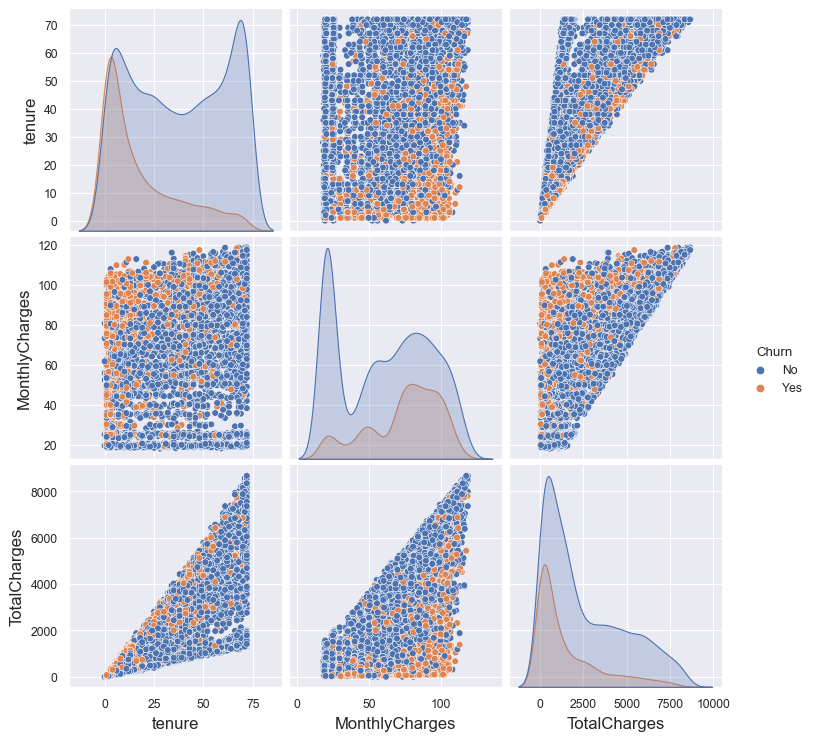

In [184]:
sns.set_context('paper', rc={'axes.labelsize':12})
sns.pairplot(churn, hue='Churn')
plt.show()

# Build Survival Regression Models with many Features

In [201]:
churn.Churn = np.where(churn.Churn == 'Yes', 1, 0)
churn.tenure = churn.tenure + 0.001

In [203]:
churn = churn[['Churn', 'tenure', 'SeniorCitizen', 'Partner', 'Dependents',
               'PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
               'Contract', 'PaperlessBilling', 'PaymentMethod',
               'MonthlyCharges', 'TotalCharges']].copy()

In [204]:
churn.head()

,Churn,tenure,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,1.001,No,Yes,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,0,34.001,No,No,No,Yes,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,1,2.001,No,No,No,Yes,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,0,45.001,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,1,2.001,No,No,No,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [205]:
cat_features_str = ''
for col in churn.select_dtypes(include='object').columns:
    cat_features_str += f'C({col}) + '

In [207]:
formula = cat_features_str + 'MonthlyCharges + TotalCharges'
formula

'C(SeniorCitizen) + C(Partner) + C(Dependents) + C(PhoneService) + C(InternetService) + C(OnlineSecurity) + C(OnlineBackup) + C(DeviceProtection) + C(TechSupport) + C(StreamingTV) + C(StreamingMovies) + C(Contract) + C(PaperlessBilling) + C(PaymentMethod) + MonthlyCharges + TotalCharges'

## The Cox proportional hazard model

In [213]:
cph = lf.CoxPHFitter(penalizer=0.1)

cph.fit(df = churn,
         duration_col = 'tenure',
         event_col = 'Churn',
         formula = formula)

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [214]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -13935.27
         time fit was run = 2023-03-23 11:18:11 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
C(Contract)[T.One year]                      -0.66       0.52       0.06            -0.77            -0.55                 0.46                 0.58
C(Contract)[T.Two year]                      -1.06       0.35       0.07            -1.19            -0.92                 0.31                 0.40
C(Dependents)[T.Yes]                         -0.15       0.86       0.05            -0.25            -0.05                 0.78                 0.95
C(DeviceProtection)[T.No internet service]   -0.22       0.80       0.09            -0.39            -0.05                 0.68                 0.95
C(DeviceProtection)[T.Yes]                   -0.18       0.83       0.05            -0.27            -0.09                 0.76                 0.91
C(InternetService)[T.Fiber optic]             0.47       1.59       0.05             0.36             0.57                 1.44                 1.77
C(InternetService)[T.No]                     -0.22       0.80       0.09            -0.39            -0.05                 0.68                 0.95
C(OnlineBackup)[T.No internet service]       -0.22       0.80       0.09            -0.39            -0.05                 0.68                 0.95
C(OnlineBackup)[T.Yes]                       -0.31       0.73       0.04            -0.40            -0.22                 0.67                 0.80
C(OnlineSecurity)[T.No internet service]     -0.22       0.80       0.09            -0.39            -0.05                 0.68                 0.95
C(OnlineSecurity)[T.Yes]                     -0.42       0.66       0.05            -0.52            -0.32                 0.59                 0.72
C(PaperlessBilling)[T.Yes]                    0.18       1.20       0.04             0.09             0.27                 1.09                 1.31
C(Partner)[T.Yes]                            -0.31       0.73       0.04            -0.40            -0.23                 0.67                 0.80
C(PaymentMethod)[T.Credit card (automatic)]  -0.19       0.82       0.06            -0.31            -0.08                 0.73                 0.92
C(PaymentMethod)[T.Electronic check]          0.38       1.47       0.05             0.29             0.47                 1.34                 1.61
C(PaymentMethod)[T.Mailed check]              0.24       1.27       0.06             0.13             0.35                 1.13                 1.43
C(PhoneService)[T.Yes]                        0.15       1.16       0.08            -0.00             0.30                 1.00                 1.35
C(SeniorCitizen)[T.Yes]                       0.04       1.04       0.05            -0.06             0.13                 0.94                 1.14
C(StreamingMovies)[T.No internet service]    -0.22       0.80       0.09            -0.39            -0.05                 0.68                 0.95
C(StreamingMovies)[T.Yes]                     0.01       1.01       0.04            -0.08             0.10                 0.92                 1.10
C(StreamingTV)[T.No internet service]        -0.22       0.80       0.09            -0.39            -0.05                 0.68                 0.95
C(StreamingTV)[T.Yes]                         0.03       1.03       0.04            -0.05             0.12                 0.95                 

<AxesSubplot:xlabel='log(HR) (95% CI)'>

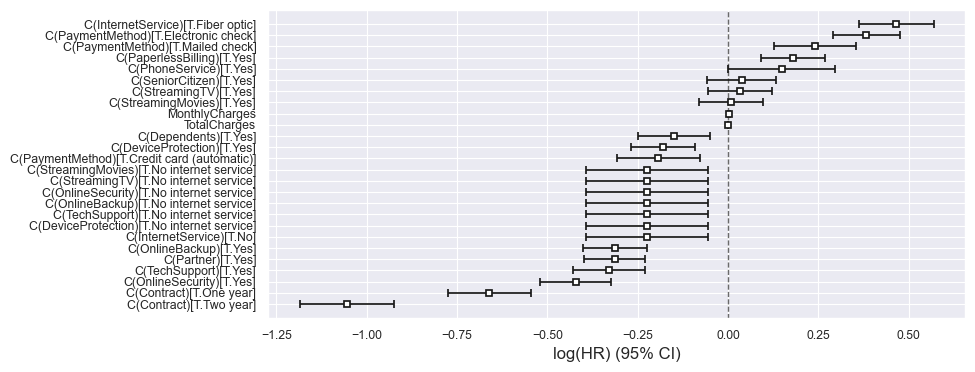

In [215]:
cph.plot()

The coefficients in a Cox regression relate to hazard; a positive coefficient indicates a worse prognosis and a negative coefficient indicates a protective effect of the variable with which it is associated.

## The Weibull AFT model

In [208]:
wft = lf.WeibullAFTFitter()

wft.fit(df = churn,
         duration_col = 'tenure',
         event_col = 'Churn',
         formula = formula)

<lifelines.WeibullAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [210]:
wft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
   number of observations = 7043
number of events observed = 1869
           log-likelihood = -8143.13
         time fit was run = 2023-03-23 11:14:18 UTC

---
                                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                           
lambda_ Intercept                                     3.14      23.06       0.18             2.78             3.49                16.15                32.93
        C(Contract)[T.One year]                       0.53       1.70       0.07             0.40             0.66                 1.49                 1.93
        C(Contract)[T.Two year]                       1.20       3.33       0.12             0.97             1.44                 2.63                 4.22
        C(Dependents)[T.Yes]                          0.10       1.11       0.05             0.01             0.20                 1.01                 1.22
        C(DeviceProtection)[T.No internet service]    0.16       1.17       0.03             0.10             0.21                 1.11                 1.23
        C(DeviceProtection)[T.Yes]                   -0.00       1.00       0.05            -0.10             0.09                 0.90                 1.10
        C(InternetService)[T.Fiber optic]            -0.63       0.53       0.18            -0.98            -0.28                 0.38                 0.76
        C(InternetService)[T.No]                      0.16       1.17       0.03             0.10             0.21                 1.11                 1.23
        C(OnlineBackup)[T.No internet service]        0.16       1.17       0.03             0.10             0.21                 1.11                 1.23
        C(OnlineBackup)[T.Yes]                        0.05       1.05       0.05            -0.05             0.14                 0.95                 1.16
        C(OnlineSecurity)[T.No internet service]      0.16       1.17       0.03             0.10             0.21                 1.11                 1.23
        C(OnlineSecurity)[T.Yes]                      0.20       1.23       0.06             0.09             0.32                 1.10                 1.37
        C(PaperlessBilling)[T.Yes]                   -0.11       0.89       0.04            -0.19            -0.03                 0.83                 0.97
        C(Partner)[T.Yes]                             0.11       1.12       0.04             0.04             0.19                 1.04                 1.21
        C(PaymentMethod)[T.Credit card (automatic)]   0.04       1.04       0.06            -0.08             0.17                 0.92                 1.18
        C(PaymentMethod)[T.Electronic check]         -0.26       0.77       0.05            -0.36            -0.16                 0.70                 0.85
        C(PaymentMethod)[T.Mailed check]             -0.27       0.77       0.06            -0.39            -0.15                 0.68                 0.86
        C(PhoneService)[T.Yes]                       -0.19       0.83       0.16            -0.51             0.12                 0.60                 1.13
        C(SeniorCitizen)[T.Yes]                      -0.03       0.97       0.04            -0.10             0.05                 0.90                 1.05
        C(StreamingMovies)[T.No internet service]     0.16       1.17       0.03             0.10             0.21                 1.11                 1.23
        C(StreamingMovies)[T.Yes]                    -0.13       0.87       0.08            -0.28             0.02                 0.75                 1.02
        C(StreamingTV)[T.No internet service]         0.

<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

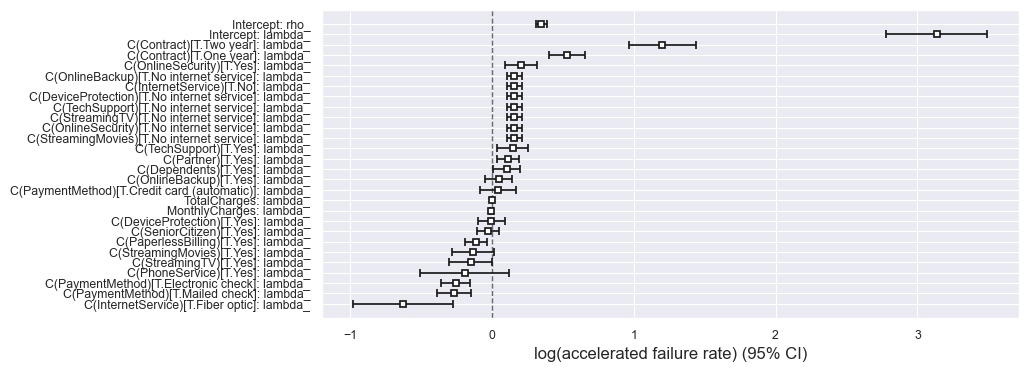

In [211]:
wft.plot()

Both models showed very similar results:
* Fiber optic Internet Service leads to smaller time with the company
* Electronic and Mailed checks instead of other types of Payment Method lead to smaller time
* Contracts for One and Two years lead to more time with the company (instead of Month-to-Month contracts)
* MonthlyCharges and TotalCharges don't affect survival time

# Build models with less features

<b>C(SeniorCitizen) + C(Partner) + C(Dependents) + C(PhoneService) + C(InternetService) + C(Contract) + C(PaperlessBilling) + C(PaymentMethod)</b>

* Some features show that customers leave the company less if they have 'No internet service'. Let's delete that features from the model and make research without them: StreamingMovies, StreamingTV, OnlineSecurity, OnlineBackup, TechSupport, DeviceProtection because that features are correlated with InternetService feature

In [228]:
cat_features_str = ''
for col in churn.select_dtypes(include='object').columns:
    if col not in ['StreamingMovies', 'StreamingTV', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'DeviceProtection']:
        cat_features_str += f'C({col}) + '

In [229]:
formula = cat_features_str[:-3]
formula

'C(SeniorCitizen) + C(Partner) + C(Dependents) + C(PhoneService) + C(InternetService) + C(Contract) + C(PaperlessBilling) + C(PaymentMethod)'

## The Cox proportional hazard model

In [230]:
cph = lf.CoxPHFitter()

cph.fit(df = churn,
         duration_col = 'tenure',
         event_col = 'Churn',
         formula = formula)

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [231]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -14133.19
         time fit was run = 2023-03-23 11:31:33 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
C(Contract)[T.One year]                      -1.92       0.15       0.09            -2.09            -1.75                 0.12                 0.17
C(Contract)[T.Two year]                      -3.71       0.02       0.16            -4.03            -3.40                 0.02                 0.03
C(Dependents)[T.Yes]                         -0.07       0.93       0.07            -0.21             0.06                 0.81                 1.06
C(InternetService)[T.Fiber optic]             0.35       1.41       0.07             0.21             0.48                 1.23                 1.62
C(InternetService)[T.No]                     -0.28       0.76       0.11            -0.50            -0.06                 0.61                 0.94
C(PaperlessBilling)[T.Yes]                    0.13       1.13       0.06             0.02             0.24                 1.02                 1.27
C(Partner)[T.Yes]                            -0.61       0.54       0.05            -0.71            -0.50                 0.49                 0.61
C(PaymentMethod)[T.Credit card (automatic)]  -0.07       0.94       0.09            -0.24             0.11                 0.78                 1.12
C(PaymentMethod)[T.Electronic check]          0.65       1.91       0.07             0.51             0.78                 1.66                 2.19
C(PaymentMethod)[T.Mailed check]              0.68       1.97       0.09             0.51             0.85                 1.66                 2.35
C(PhoneService)[T.Yes]                       -0.11       0.89       0.10            -0.30             0.08                 0.74                 1.08
C(SeniorCitizen)[T.Yes]                      -0.08       0.92       0.06            -0.19             0.03                 0.83                 1.03

                                              cmp to      z      p   -log2(p)
covariate                                                                    
C(Contract)[T.One year]                         0.00 -22.44 <0.005     368.06
C(Contract)[T.Two year]                         0.00 -23.10 <0.005     389.91
C(Dependents)[T.Yes]                            0.00  -1.05   0.29       1.76
C(InternetService)[T.Fiber optic]               0.00   4.96 <0.005      20.42
C(InternetService)[T.No]                        0.00  -2.47   0.01       6.19
C(PaperlessBilling)[T.Yes]                      0.00   2.23   0.03       5.30
C(Partner)[T.Yes]                               0.00 -11.12 <0.005      92.97
C(PaymentMethod)[T.Credit card (automatic)]     0.00  -0.73   0.47       1.10
C(PaymentMethod)[T.Electronic check]            0.00   9.14 <0.005      63.79
C(PaymentMethod)[T.Mailed check]                0.00   7.68 <0.005      45.86
C(PhoneService)[T.Yes]                          0.00  -1.15   0.25       2.00
C(SeniorCitizen)[T.Yes]                         0.00  -1.44   0.15       2.74
---
Concordance = 0.84
Partial AIC = 28290.37
log-likelihood ratio test = 3039.71 on 12 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

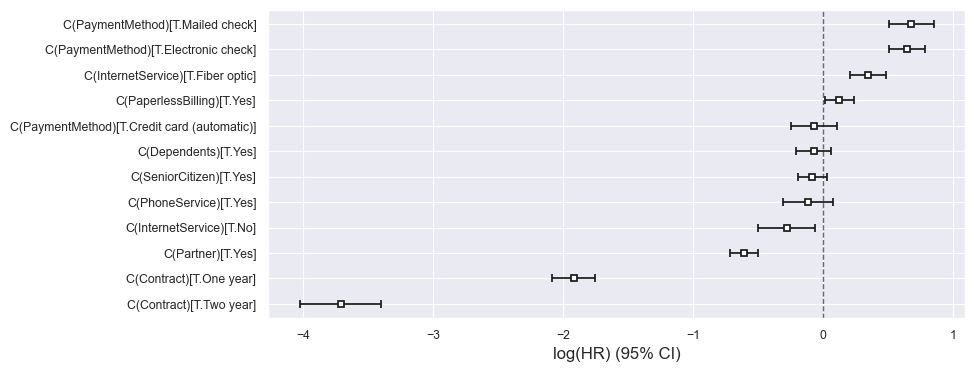

In [232]:
cph.plot()

## The Weibull AFT model

In [233]:
wft = lf.WeibullAFTFitter()

wft.fit(df = churn,
         duration_col = 'tenure',
         event_col = 'Churn',
         formula = formula)

<lifelines.WeibullAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [234]:
wft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
   number of observations = 7043
number of events observed = 1869
           log-likelihood = -9147.84
         time fit was run = 2023-03-23 11:32:23 UTC

---
                                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                           
lambda_ Intercept                                     4.27      71.87       0.13             4.02             4.53                55.85                92.48
        C(Contract)[T.One year]                       2.12       8.31       0.10             1.92             2.32                 6.80                10.15
        C(Contract)[T.Two year]                       3.73      41.85       0.19             3.37             4.10                29.10                60.21
        C(Dependents)[T.Yes]                          0.12       1.13       0.08            -0.04             0.28                 0.96                 1.32
        C(InternetService)[T.Fiber optic]            -0.41       0.66       0.08            -0.58            -0.25                 0.56                 0.78
        C(InternetService)[T.No]                      0.31       1.36       0.13             0.05             0.57                 1.05                 1.77
        C(PaperlessBilling)[T.Yes]                   -0.15       0.86       0.07            -0.28            -0.02                 0.75                 0.98
        C(Partner)[T.Yes]                             0.67       1.95       0.06             0.54             0.79                 1.72                 2.20
        C(PaymentMethod)[T.Credit card (automatic)]   0.06       1.07       0.11            -0.15             0.27                 0.86                 1.31
        C(PaymentMethod)[T.Electronic check]         -0.75       0.47       0.08            -0.92            -0.59                 0.40                 0.56
        C(PaymentMethod)[T.Mailed check]             -0.81       0.44       0.10            -1.02            -0.61                 0.36                 0.54
        C(PhoneService)[T.Yes]                        0.14       1.15       0.12            -0.09             0.37                 0.92                 1.45
        C(SeniorCitizen)[T.Yes]                       0.08       1.08       0.07            -0.05             0.21                 0.95                 1.23
rho_    Intercept                                    -0.17       0.85       0.02            -0.20            -0.13                 0.81                 0.88

                                                      cmp to     z      p   -log2(p)
param   covariate                                                                   
lambda_ Intercept                                       0.00 33.23 <0.005     801.79
        C(Contract)[T.One year]                         0.00 20.70 <0.005     313.69
        C(Contract)[T.Two year]                         0.00 20.13 <0.005     296.93
        C(Dependents)[T.Yes]                            0.00  1.47   0.14       2.82
        C(InternetService)[T.Fiber optic]               0.00 -5.00 <0.005      20.71
        C(InternetService)[T.No]                        0.00  2.30   0.02       5.53
        C(PaperlessBilling)[T.Yes]                      0.00 -2.29   0.02       5.51
        C(Partner)[T.Yes]                               0.00 10.50 <0.005      83.21
        C(PaymentMethod)[T.Credit card (automatic)]     0.00  0.59   0.56       0.85
        C(PaymentMethod)[T.Electronic check]            0.00 -8.98 <0.005      61.66
        C(PaymentMethod)[T.Mailed check]                0.00 -7.86 <0.005      47.90
        C(PhoneService)[T.Yes]                   

<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

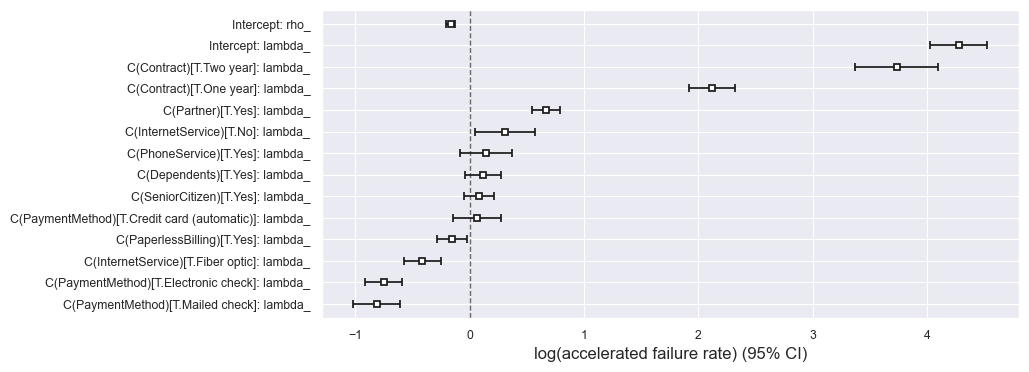

In [235]:
wft.plot()

<b>C(SeniorCitizen) + C(Partner) + C(Dependents) + C(PhoneService) + C(InternetService) + C(PaperlessBilling) + C(PaymentMethod)</b>

* Long Contracts lead to longer time with the company. Let's remove that feature to understand dependencies among the rest features better

In [236]:
cat_features_str = ''
for col in churn.select_dtypes(include='object').columns:
    if col not in ['StreamingMovies', 'StreamingTV', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'DeviceProtection',
                   'Contract']:
        cat_features_str += f'C({col}) + '

In [237]:
formula = cat_features_str[:-3]
formula

'C(SeniorCitizen) + C(Partner) + C(Dependents) + C(PhoneService) + C(InternetService) + C(PaperlessBilling) + C(PaymentMethod)'

## The Cox proportional hazard model

In [238]:
cph = lf.CoxPHFitter()

cph.fit(df = churn,
         duration_col = 'tenure',
         event_col = 'Churn',
         formula = formula)

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [239]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -14885.53
         time fit was run = 2023-03-23 11:36:53 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
C(Dependents)[T.Yes]                         -0.20       0.82       0.07            -0.33            -0.06                 0.72                 0.94
C(InternetService)[T.Fiber optic]             0.67       1.96       0.07             0.54             0.81                 1.71                 2.24
C(InternetService)[T.No]                     -0.71       0.49       0.11            -0.93            -0.49                 0.39                 0.62
C(PaperlessBilling)[T.Yes]                    0.26       1.30       0.06             0.15             0.37                 1.16                 1.45
C(Partner)[T.Yes]                            -0.82       0.44       0.05            -0.93            -0.72                 0.40                 0.49
C(PaymentMethod)[T.Credit card (automatic)]  -0.08       0.93       0.09            -0.25             0.10                 0.78                 1.11
C(PaymentMethod)[T.Electronic check]          1.10       2.99       0.07             0.96             1.24                 2.60                 3.44
C(PaymentMethod)[T.Mailed check]              0.98       2.66       0.09             0.81             1.15                 2.24                 3.16
C(PhoneService)[T.Yes]                       -0.27       0.76       0.10            -0.46            -0.08                 0.63                 0.92
C(SeniorCitizen)[T.Yes]                       0.13       1.13       0.06             0.02             0.23                 1.02                 1.26

                                              cmp to      z      p   -log2(p)
covariate                                                                    
C(Dependents)[T.Yes]                            0.00  -2.89 <0.005       8.03
C(InternetService)[T.Fiber optic]               0.00   9.72 <0.005      71.80
C(InternetService)[T.No]                        0.00  -6.26 <0.005      31.24
C(PaperlessBilling)[T.Yes]                      0.00   4.66 <0.005      18.30
C(Partner)[T.Yes]                               0.00 -15.23 <0.005     171.50
C(PaymentMethod)[T.Credit card (automatic)]     0.00  -0.84   0.40       1.32
C(PaymentMethod)[T.Electronic check]            0.00  15.43 <0.005     176.01
C(PaymentMethod)[T.Mailed check]                0.00  11.18 <0.005      93.99
C(PhoneService)[T.Yes]                          0.00  -2.80   0.01       7.62
C(SeniorCitizen)[T.Yes]                         0.00   2.25   0.02       5.37
---
Concordance = 0.75
Partial AIC = 29791.05
log-likelihood ratio test = 1535.02 on 10 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

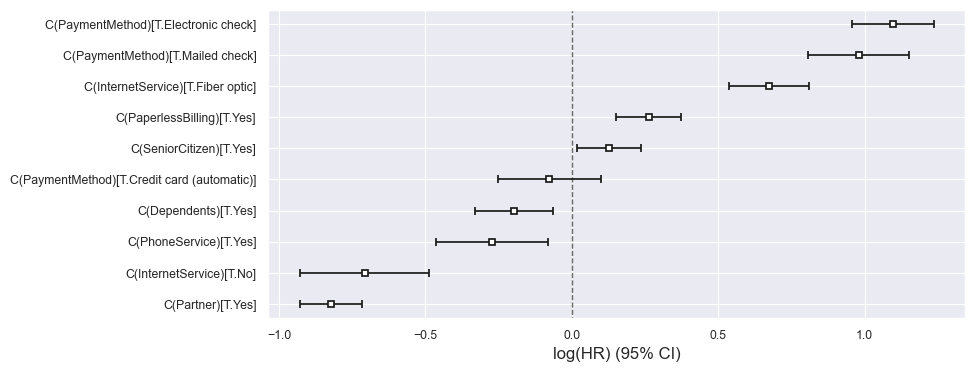

In [240]:
cph.plot()

## The Weibull AFT model

In [241]:
wft = lf.WeibullAFTFitter()

wft.fit(df = churn,
         duration_col = 'tenure',
         event_col = 'Churn',
         formula = formula)

<lifelines.WeibullAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [242]:
wft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
   number of observations = 7043
number of events observed = 1869
           log-likelihood = -9811.06
         time fit was run = 2023-03-23 11:37:08 UTC

---
                                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                           
lambda_ Intercept                                     5.81     333.02       0.15             5.51             6.11               247.00               449.00
        C(Dependents)[T.Yes]                          0.28       1.33       0.09             0.10             0.47                 1.10                 1.60
        C(InternetService)[T.Fiber optic]            -0.92       0.40       0.10            -1.11            -0.73                 0.33                 0.48
        C(InternetService)[T.No]                      0.98       2.66       0.16             0.67             1.29                 1.95                 3.63
        C(PaperlessBilling)[T.Yes]                   -0.36       0.70       0.08            -0.52            -0.21                 0.60                 0.81
        C(Partner)[T.Yes]                             1.13       3.09       0.07             0.98             1.28                 2.67                 3.58
        C(PaymentMethod)[T.Credit card (automatic)]   0.11       1.11       0.13            -0.14             0.35                 0.87                 1.42
        C(PaymentMethod)[T.Electronic check]         -1.50       0.22       0.10            -1.70            -1.31                 0.18                 0.27
        C(PaymentMethod)[T.Mailed check]             -1.36       0.26       0.12            -1.59            -1.12                 0.20                 0.33
        C(PhoneService)[T.Yes]                        0.37       1.44       0.14             0.10             0.63                 1.11                 1.88
        C(SeniorCitizen)[T.Yes]                      -0.16       0.86       0.08            -0.31            -0.00                 0.73                 1.00
rho_    Intercept                                    -0.33       0.72       0.02            -0.37            -0.29                 0.69                 0.75

                                                      cmp to      z      p   -log2(p)
param   covariate                                                                    
lambda_ Intercept                                       0.00  38.10 <0.005        inf
        C(Dependents)[T.Yes]                            0.00   2.98 <0.005       8.43
        C(InternetService)[T.Fiber optic]               0.00  -9.39 <0.005      67.17
        C(InternetService)[T.No]                        0.00   6.19 <0.005      30.66
        C(PaperlessBilling)[T.Yes]                      0.00  -4.61 <0.005      17.95
        C(Partner)[T.Yes]                               0.00  15.08 <0.005     168.37
        C(PaymentMethod)[T.Credit card (automatic)]     0.00   0.85   0.39       1.35
        C(PaymentMethod)[T.Electronic check]            0.00 -15.01 <0.005     166.73
        C(PaymentMethod)[T.Mailed check]                0.00 -11.13 <0.005      93.15
        C(PhoneService)[T.Yes]                          0.00   2.72   0.01       7.24
        C(SeniorCitizen)[T.Yes]                         0.00  -2.02   0.04       4.53
rho_    Intercept                                       0.00 -16.43 <0.005     199.01
---
Concordance = 0.75
AIC = 19646.13
log-likelihood ratio test = 1530.97 on 10 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

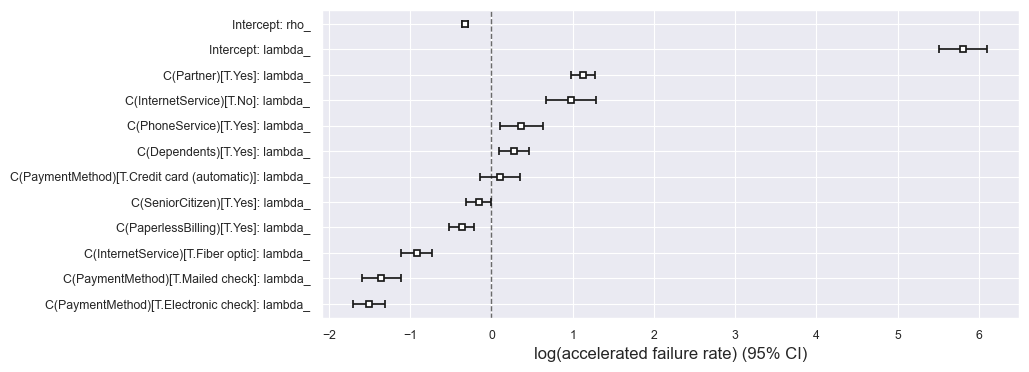

In [244]:
wft.plot()

Factors that help to stay with the company longer:
* Partner = Yes
* InternetService = No
* PhoneService = Yes
* Dependents = Yes

Factors that lead to leaving the company faster:
* PaymentMethod = Electronic check or Mailed check
* InternetService = Fiber optic
* PaperlessBilling = Yes

Analysis conclusion for the business:

* No Internet Service leeds to customers with longer life with company. However, business may want to check the Internet Service dependencies and decreese churn for customers with it
* Something may be wrong with Internet via Fiber optic
* Paperless Billing system may have some issues
* Customers with Partner and with Dependents in family are the target clients of the company now. Single customers (in different censes) can be a segment of further researches

Models comparison:
* AIC is lower - the model is better
* Among 2 types the Weibull AFT model showed better AIC value than the Cox proportional hazard model
* Models with less parameters have a bit higher AIC value. But not significantly

# Analysis Summary

## Points of growth (company may run further researches to understand Churn in this categories)

* Month-to-month contracts
* Customers of the first year
* Internet Service (Fiber optics)
* Paperless Bills (Electronic and Mailed checks)
* Single customers (without Partner or Dependent)

## Current target audience

* Customers with Partner and with Dependents in family